In [1]:
import json
import bz2
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:14, 1490.80it/s]


### Домашнее задание по NLP # 1 [100 баллов]

#### Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [5]:
list(responses[99].keys())

['city',
 'rating_not_checked',
 'title',
 'num_comments',
 'bank_license',
 'author',
 'bank_name',
 'datetime',
 'text',
 'rating_grade']

In [6]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [7]:
# Предобработка, Оставляем только слова:

import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    if text != None:
        return " ".join(regex.findall(text.lower()))
    else:
        return None

In [8]:
df['city'] = df['city'].apply(words_only)
df['title'] = df['title'].apply(words_only)
df['text'] = df['text'].apply(words_only)
df['bank_name'] = df['bank_name'].apply(words_only)

### Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки

2. Постройте гистограмы длин слов в символах и в словах

3. Найдите 10 самых частых:

    * слов
    
    * слов без стоп-слов

    * лемм

    * существительных


1. Постройте кривые Ципфа и Хипса

2. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?

    * сколько раз встречается слова "мошенничество" и "доверие"?

3. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [31]:
# 1. Посчитайте количество отзывов в разных городах и на разные банки

In [9]:
df['city'].value_counts()

г москва                   56727
г санкт петербург          14994
г новосибирск               2380
г екатеринбург              2374
г нижний новгород           2035
                           ...  
г челбинск                     1
г нововаршавка                 1
г курган курганской обл        1
г с бея                        1
г лазаревское                  1
Name: city, Length: 4697, dtype: int64

In [10]:
df['bank_name'].value_counts()

сбербанк россии                                  26327
альфа банк                                       10224
втб                                               8296
русский стандарт                                  7943
хоум кредит банк                                  7549
                                                 ...  
бумеранг                                             1
индустриальный сберегательный банк                   1
москва сити                                          1
юникбанк                                             1
межрегиональный промышленно строительный банк        1
Name: bank_name, Length: 668, dtype: int64

In [11]:
df1 = df.groupby(['city', 'bank_name']).count()[['text']]
df1
#df.groupby(['city', 'bank_name']).agg('count').reset_index().sort_values(by=['city'])

text
city     bank_name             
г        авангард            10
         ак барс              1
         альфа банк          15
         амт банк             2
         балтийский банк      2
...                         ...
г яхрома дельтакредит         1
         сбербанк россии      1
         ситибанк             1
г яшалта россельхозбанк       1
г яшкино хоум кредит банк     1

[16650 rows x 1 columns]

In [36]:
# 2. Постройте гистограмы длин отзывов в символах и в словах

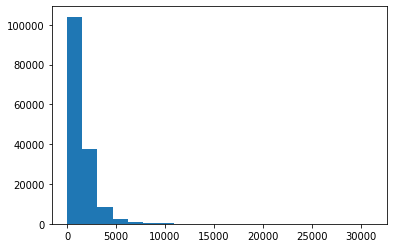

In [12]:
# длины в символах
df2 = df.copy()
df2['lenotz_s'] = df2['text'].apply(lambda x: len(x))
plt.hist(df2['lenotz_s'], bins=20)
plt.show()

In [13]:
max(df2['lenotz_s'])

31053

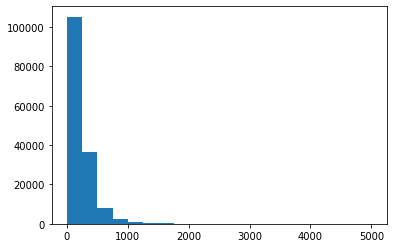

In [14]:
# длины в словах
df2['lenotz_w'] = df2['text'].apply(lambda x: len(x.split(' ')))
plt.hist(df2['lenotz_w'], bins=20)
plt.show()

In [15]:
max(df2['lenotz_w'])

5001

In [120]:
# 3. Найдите 10 самых частых: * слов, * слов без стоп-слов, * лемм, * существительных

from collections import Counter

In [124]:
df2['lemmata'] = df2['text'].apply([lambda x: lemma for text in x for lemma in x.split(' ')])

NameError: name 'x' is not defined

In [12]:
a = list(df['text'].apply(lambda x: x.split(' ')))
 

In [127]:
words = ' '.join(list(df['text'])).split(sep=' ')

MemoryError: 

In [125]:

popular = df.groupby(0).count().reset_index()
popular.columns = ['word', 'count']
popular.sort_values(by='count', ascending=False).head(10)

KeyError: 0

### Часть 2. Тематическое моделирование [20/100]
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

 * 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
 * 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Используйте accuracy и F-measure для оценки качества классификации.

Ниже написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])